In [3]:
import numpy as np # 선형대수 모듈
import matplotlib.pyplot as plt # 시각화 모듈
import torch # 파이토치
import torch.nn as nn # PyTorch의 모듈을 모아놓은 것. from~~이 아닌 저렇게 임포트를 하는 것이 거의 관습이라고 한다.
import torch.nn.functional as F # torch.nn 중에서 자주 쓰는 함수를 F로 임포트.
import torch.nn.init as init # 초기화 관련 모듈 
import torchvision # TorchVision 임포트
from torchvision import transforms, datasets,utils # 데이터를 다루기 위한 TorchVision 내의 Transforms와 datasets를 따로 임포트

DEVICE = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

BATCH_SIZE = 32
EPOCHS = 5

print('Using PyTorch version: ', torch.__version__, 'Device: ', DEVICE)


Using PyTorch version:  1.13.1 Device:  cpu


In [4]:
train_dataset = datasets.MNIST(
    root="./MNIST_data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
test_dataset = datasets.MNIST(
    root="./MNIST_data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

for (X_train, y_train) in train_loader:
    print('X_train: ', X_train.size(), 'type: ', X_train.type())
    print('y_train: ', y_train.size(), 'type: ', y_train.type())
    break



X_train:  torch.Size([32, 1, 28, 28]) type:  torch.FloatTensor
y_train:  torch.Size([32]) type:  torch.LongTensor


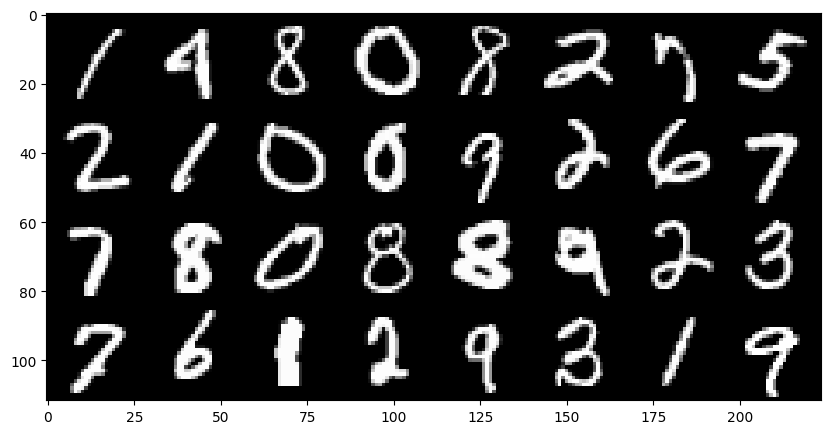

In [5]:
dataiter       = iter(train_loader) #배치 1개만 뽑아 데이터가 생긴 형태를 살펴보겠습니다
images, labels = next(dataiter)

# 여러 이미지 모아보기
img   = utils.make_grid(images, padding=0) # util.make_grid() 함수를 이용해 여러 이미지를 하나로 모아 하나의 이미지로 만듭니다
npimg = img.numpy() # img는 파이토치 텐서입니다. numpy()함수로 맷플롯립과 호환이 되는 넘파이 행렬로 바꿔줍니다.
plt.figure(figsize=(10, 7))
plt.imshow(np.transpose(npimg, (1,2,0))) #np.transpose() 함수를 이용해 첫 번째(0번째) 차원을 맨 뒤로 보냅니다
plt.show()
# 여러 개의 패션 아이템이 흑백으로 나열되는 것을 볼 수 있습니다

In [6]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout_prob = 0.5 # 50%의 노드에 대한 가중치 계산을 하지 않기 위한 설정
        self.batch_norm1 = nn.BatchNorm1d(512) # 1dimension이기 때문에 BatchNorm1d를 사용함.
        self.batch_norm2 = nn.BatchNorm1d(256)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = self.batch_norm1(x)
        x = F.relu(x) # sigmoid(x)
        x = F.dropout(x, training=self.training, p=self.dropout_prob)
        x = self.fc2(x)
        x = self.batch_norm2(x)
        x = F.relu(x) # sigmoid(x)
        x = F.dropout(x, training=self.training, p=self.dropout_prob)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x
    


In [7]:
def weight_init(m):
    if isinstance(m, nn.Linear):
        init.kaiming_uniform_(m.weight.data)

model = MLP().to(DEVICE) # 정의한 모델을 GPU로 납치
model.apply(weight_init)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()


In [8]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = loss_fn(output, label)
        loss.backward()
        optimizer.step()

In [9]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += loss_fn(output, label).item()
            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [10]:
for Epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval=100)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} %".format(
        Epoch, test_loss, test_accuracy
    ))

[EPOCH: 1], 	Test Loss: 0.0039, 	Test Accuracy: 96.25 %
[EPOCH: 2], 	Test Loss: 0.0033, 	Test Accuracy: 96.74 %
[EPOCH: 3], 	Test Loss: 0.0030, 	Test Accuracy: 97.09 %
[EPOCH: 4], 	Test Loss: 0.0029, 	Test Accuracy: 97.25 %
[EPOCH: 5], 	Test Loss: 0.0025, 	Test Accuracy: 97.54 %
